In [1]:
from __future__ import print_function
from builtins import input
import cv2 as cv
import numpy as np
import argparse
from matplotlib import pyplot as plt
import os
import glob
import os
import numpy as np
from skimage.filters import gaussian
import dlib
import math
from PIL import Image, ImageDraw

In [2]:
def sharpen(img):
    img = img * 1.0
    gauss_out = gaussian(img, sigma=5, multichannel=True)

    alpha = 1.5
    img_out = (img - gauss_out) * alpha + img

    img_out = img_out / 255.0

    mask_1 = img_out < 0
    mask_2 = img_out > 1

    img_out = img_out * (1 - mask_1)
    img_out = img_out * (1 - mask_2) + mask_2
    img_out = np.clip(img_out, 0, 1)
    img_out = img_out * 255
    return np.array(img_out, dtype=np.uint8)


def hair(image, parsing, part=17, color=[230, 50, 20]):
    b, g, r = color      #[10, 50, 250]       # [10, 250, 10]
    tar_color = np.zeros_like(image)
    tar_color[:, :, 0] = b
    tar_color[:, :, 1] = g
    tar_color[:, :, 2] = r

    image_hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    tar_hsv = cv.cvtColor(tar_color, cv.COLOR_BGR2HSV)

    if part == 12 or part == 13:
        image_hsv[:, :, 0:2] = tar_hsv[:, :, 0:2]
    else:
        image_hsv[:, :, 0:1] = tar_hsv[:, :, 0:1]

    changed = cv.cvtColor(image_hsv, cv.COLOR_HSV2BGR)

#     if part == 17:
#         changed = sharpen(changed)

    changed[parsing != part] = 0#image[parsing != part]
    # changed = cv.resize(changed, (512, 512))
    return changed


In [3]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

In [126]:
def getmaskcoord(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    jawline = []
    mouth = []
    eyes = []    
    eyebrows = []
    #get the jawline
    for i in range(0, 27):
        if(i>16):
            jawline.append((shape.part(i).x, shape.part(i).y-10))
        else:
            jawline.append((shape.part(i).x, shape.part(i).y))
        if(i==21):
            jawline.append((shape.part(27).x, shape.part(19).y))
#     jawline.append((shape.part(17).x, shape.part(19).y-5))
#     jawline.append((shape.part(26).x, shape.part(19).y-5))
    jawline[17:]=np.flip(jawline,axis=0)[0:11]
    jawline=np.asarray(jawline,dtype=dtype)
    #get eyebrows
    for i in range(17,27):
        eyebrows.append((shape.part(i).x, shape.part(i).y))
        if(i==21):
            eyebrows.append((shape.part(19).x, shape.part(17).y-1))
        if(i==26):
            eyebrows.append((shape.part(24).x, shape.part(26).y-1))
    
    eyebrows=np.asarray(eyebrows,dtype=dtype)
    #get eyes
    for i in range(36,48):
        eyes.append((shape.part(i).x, shape.part(i).y))
        
    eyes=np.asarray(eyes,dtype=dtype)
    #get mouth
    
    #gigi hilang
    for i in range(48,59):
    #gigi muncul
    #for i in range(48,68):
        mouth.append((shape.part(i).x, shape.part(i).y))
    
    mouth=np.asarray(mouth,dtype=dtype)
    # return the list of (x, y)-coordinates
    return jawline,eyebrows,eyes,mouth

In [134]:
def getface(img,jawline,eyebrows,eyes,mouth):
    im=img.copy()
    img = cv.cvtColor(im, cv.COLOR_RGB2GRAY)
    imArray = np.asarray(img)
    # create mask
    mouth_mask = Image.new('L', (imArray.shape[1], imArray.shape[0]), color=0)
    brows_mask = Image.new('L', (imArray.shape[1], imArray.shape[0]), color=0)
#     #create jawline
#     jaw = jawline.flatten().tolist()
#     ImageDraw.Draw(maskIm).polygon(jaw,  fill='black')
    #draw eyes
#     righteyes=eyes[0:6].flatten().tolist()
#     ImageDraw.Draw(maskIm).polygon(righteyes, fill='white')
#     lefteyes=eyes[6:].flatten().tolist()
#     ImageDraw.Draw(maskIm).polygon(lefteyes, fill='white')
    #draw eyebrows
    rightbrows=eyebrows[0:5].flatten().tolist()
    ImageDraw.Draw(brows_mask).line(rightbrows, fill='white',width=10)
    leftbrows=eyebrows[6:-1].flatten().tolist()
    ImageDraw.Draw(brows_mask).line(leftbrows, fill='white',width=10)
    # draw mouth
    mouth=mouth.flatten().tolist()
    ImageDraw.Draw(mouth_mask).polygon(mouth, fill='white')
    mouth_mask = np.array(mouth_mask)
    brows_mask = np.array(brows_mask)
    mouth = cv.bitwise_or(im,im,mask=mouth_mask)
    brows = cv.bitwise_or(im,im,mask=brows_mask)
    mask = mouth_mask#+brows_mask
    return mask,mouth,brows

In [102]:
def createmask (image_path):
    predictor_path = '/home/cgal/dlib/shape_predictor_68_face_landmarks.dat'
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path) 
    
    img = np.array(image_path)  
    rects = detector(img, 1)
    shape = predictor(img, rects[0])
    jawline,eyebrows,eyes,mouth = getmaskcoord(shape)
    mask,mouth,brows= getface(img,jawline,eyebrows,eyes,mouth)
    return mask,mouth,brows

In [65]:
templateNames=['i', 'V', 'L', 'I', 'T', 'Y', 'X' ]
region1Arcs= [18, 94, 18, 18, 180, 94, 94 ]
region2Arcs= [0, 0, 80, 18, 0, 18, 94 ]
c1toc2 =[0, 0, 90, 180, 0, 180, 180 ]

In [66]:
def applytemplate(template,starting_point,height):
    t_index = templateNames.index(str(template))
    second=starting_point+region1Arcs[t_index]
    new_hist=np.zeros(360)
    if(second<=360):
        new_hist[starting_point:second]=N[starting_point:second]    
    else:
        excess=int(second%360)
        new_hist[0:excess]=N[0:excess]
        new_hist[starting_point:360]=N[starting_point:360]
    if(region2Arcs[t_index]!=0):
        third=int(starting_point+region1Arcs[t_index]/2+c1toc2[t_index]-region2Arcs[t_index]/2)
        fourth=third+region2Arcs[t_index]
        if(third<=360):
            if(fourth<=360):
                new_hist[third:fourth]=N[third:fourth]
            else:
                excess=int(fourth%360)
                new_hist[0:excess]=N[0:excess]
                new_hist[third:360]=N[third:360]
        else:
            third=int(third%360)
            fourth=third+region2Arcs[t_index]
            new_hist[third:fourth]=N[third:fourth]
    return new_hist

In [67]:
def computedistancetoborder(template,template_point,hue_position,neigh,saturation,sat_neigh):
    t_index=templateNames.index(template)
    #Region 1 of template
    border1 = template_point
    border2 = (template_point+region1Arcs[t_index])%360
    hue_position = hue_position
    region = 1
    orientation=1 #-1=counterclockwise 1 = clockwise
    tempdistance=999
    tempenergy=999 #Default value if there are no region 2
    ori2=1
    #Formula for Energy
    compare = np.where(neigh==hue_position,0,1)
    maks=np.maximum(saturation,sat_neigh)
    h=1/np.absolute(np.subtract(hue_position,neigh))
    h=np.where(np.isinf(h), 0, h)
    E2=np.sum(compare*maks*h)
    if(border1<=hue_position) and (hue_position<=border2):
        distance = 0
        energy=0
    elif(border1>border2) and ((border1<=hue_position) or (hue_position<=border2)):
        distance = 0
        energy=0
    else:
        #ngecek ke terdekat
        d1 = abs(hue_position-border1)
        d2 = abs(hue_position-border2)
        #ngecek ke sisi yg lainnya 
        d3 = abs(360-d1)
        d4 = abs(360-d2)
        min1=min(d1,d2)
        min2=min(d3,d4)
        if(min1<min2):
            distance=min1
            if(hue_position>border1):
                ori1=-1
            elif(hue_position<border1):
                ori1=1
        else :
            distance=min2
            if(hue_position>border1):
                ori1=1
            elif(hue_position<border1):
                ori1=-1
        #distance=min(d1,d2,d3,d4)
        orientation=ori1
        E1=distance*saturation
        energy=E1+E2
    #Region 2 if available
    if(region2Arcs[t_index]!=0):
        border1=(border1+(region1Arcs[t_index]/2)+c1toc2[t_index]-(region2Arcs[t_index]/2))%360
        border2=(border1+region2Arcs[t_index])%360
        if(border1<=hue_position) and (hue_position<=border2):
            tempdistance = 0
            tempenergy=0
        elif(border1>border2) and ((border1<=hue_position) or (hue_position<=border2)):
            tempdistance = 0
            tempenergy=0
        else:
            #ngecek ke terdekat
            d1 = abs(hue_position-border1)
            d2 = abs(hue_position-border2)
            #ngecek ke sisi yg lainnya
            d3 = abs(360-d1)
            d4 = abs(360-d2)        
            min1=min(d1,d2)
            min2=min(d3,d4)
            if(min1<min2):
                tempdistance=min1
                if(hue_position>border1):
                    ori2=-1
                elif(hue_position<border1):
                    ori2=1
            else :
                tempdistance=min2
                if(hue_position>border1):
                    ori2=1
                elif(hue_position<border1):
                    ori2=-1
            #tempdistance=min(d1,d2,d3,d4)
            E1=tempdistance*saturation
            tempenergy=E1+E2
    #Check between region 1 or region 2 is closest
    if(energy>tempenergy):
        distance=tempdistance
        region = 2
        orientation=ori2
#     if(270<hue_position) and (hue_position<340):
#         print(neigh,hue_position,region)
        #region=1
    return region,distance,orientation

In [68]:
def computedistancetocenter(template,template_point,hue_position,region):
    t_index=templateNames.index(template)
    center = (template_point+region1Arcs[t_index]/2)%360
    tempdistance=999 #Default value if there are no region 2
    #center of region1
    if(region==1):
        #ngecek ke kiri
        d1 = abs(hue_position-center)
        #ngecek ke kanan
        d2 = abs(360-d1)
        distance=min(d1,d2)
    #Region 2 if available
    elif(region==2):
        center=(center+c1toc2[t_index])%360
        #ngecek ke kiri
        d1 = abs(hue_position-center)
        #ngecek ke kanan
        d2 = abs(360-d1)
        distance=min(d1,d2)
    #Check between region 1 or region 2 is closest
    return distance

In [69]:
def fittoregion(template,template_point,hue_point,neigh,saturation,sat_neigh):
    t_index=templateNames.index(template)
    region,_,orientation= computedistancetoborder(template,template_point,hue_point,neigh,saturation,sat_neigh)
    distance= computedistancetocenter(template,template_point,hue_point,region)
    if(region==1):
        center = (template_point+region1Arcs[t_index]/2)%360
        w = region1Arcs[t_index]
    else:
        center = (template_point+region1Arcs[t_index]/2+c1toc2[t_index])%360
        w = region2Arcs[t_index]
    #distance=abs(hue_point-center)
    new_value=round(center+orientation*(w/2)*(1-(math.exp(-distance*distance/(2*((w/2)**2))))))%360
    return new_value

In [70]:
def recalculatehist(im,template,template_point):
    image=im.copy()
    hues=np.round(image[:,:,0]/255*360)
    saturation = image[:,:,1]
    new_hues=hues.copy()
    hues = np.pad(hues, pad_width=1, mode='constant', constant_values=0)
    saturation = np.pad(saturation, pad_width=1, mode='constant', constant_values=0)
    row,col=hues.shape
    #convert->area yang harus dipindah
    #new_mapping = (value lama, value baru)
    for i in range (1,row-1):
        for j in range (1,col-1):
            neighbour=hues[i-1:i+2,j-1:j+2].flatten()
            sat_neigh=saturation[i-1:i+2,j-1:j+2].flatten()
            #delete middle matrix
            neighbour=np.delete(neighbour,4)
            sat=sat_neigh[4]
            sat_neigh=np.delete(sat_neigh,4)
            new_value=fittoregion(template,template_point,hues[i,j],neighbour,sat,sat_neigh)
            new_hues[i-1,j-1]=new_value
    return new_hues

In [127]:
def color_harmonize(img):
    ori_image=img.copy()
    image = cv.cvtColor(ori_image,cv.COLOR_BGR2HSV_FULL)
    hues=np.round(image[:,:,0]/255*360)
    saturation = image[:,:,1]
    new_hues=hues.copy()
    hues = np.pad(hues, pad_width=1, mode='constant', constant_values=0)
    saturation = np.pad(saturation, pad_width=1, mode='constant', constant_values=0)
    row,col=hues.shape
    template,template_point='i',0
    for i in range (1,row-1):
        for j in range (1,col-1):
            neighbour=hues[i-1:i+2,j-1:j+2].flatten()
            sat_neigh=saturation[i-1:i+2,j-1:j+2].flatten()
            #delete middle matrix
            neighbour=np.delete(neighbour,4)
            sat=sat_neigh[4]
            sat_neigh=np.delete(sat_neigh,4)
            new_value=fittoregion(template,int(template_point),hues[i,j],neighbour,sat,sat_neigh)
            new_hues[i-1,j-1]=new_value
    new_hues=np.round(new_hues/360*255)
    image[:,:,0]=new_hues
    new_image = cv.cvtColor(image,cv.COLOR_HSV2RGB_FULL)    
    return new_image

/home/cgal/anaconda3/envs/cafe/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/cgal/anaconda3/envs/cafe/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


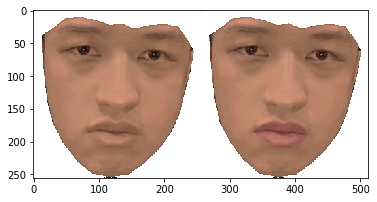

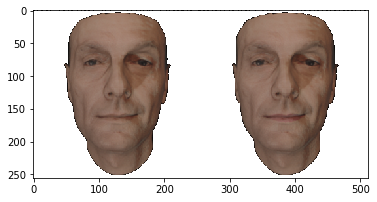

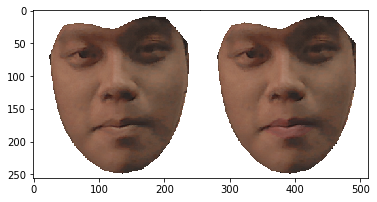

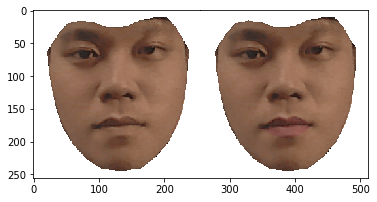

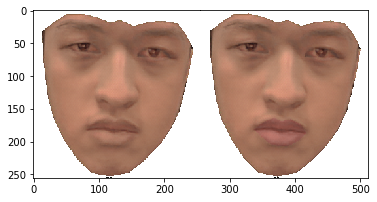

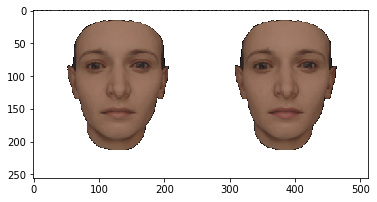

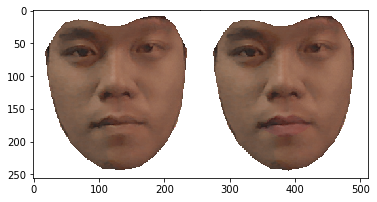

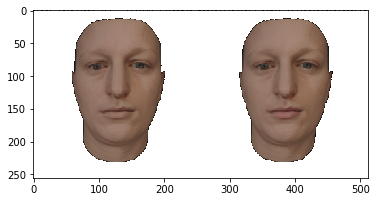

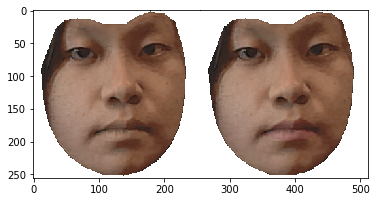

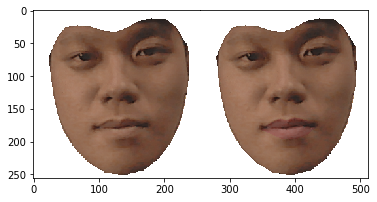

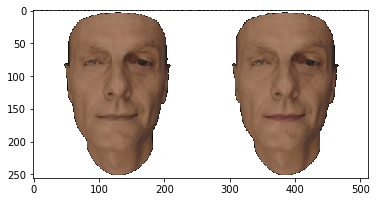

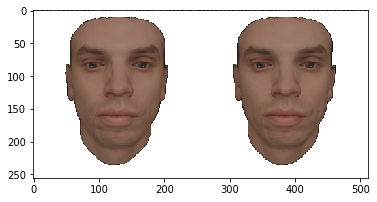

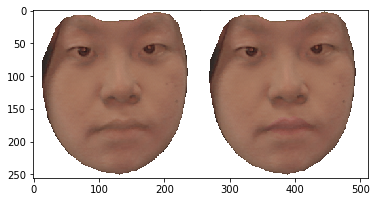

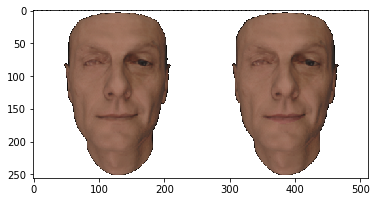

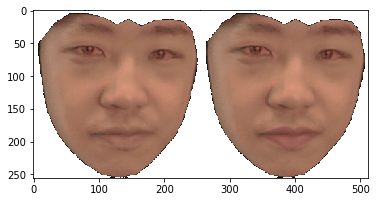

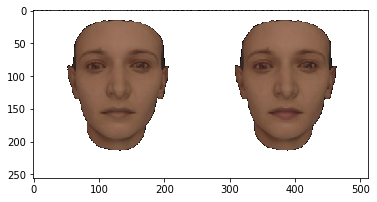

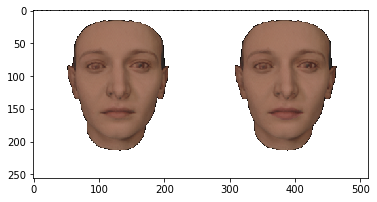

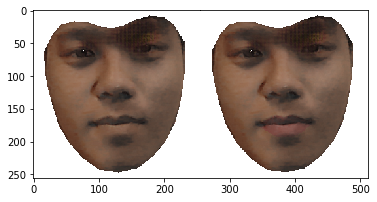

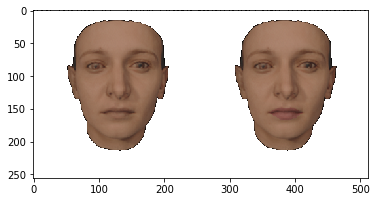

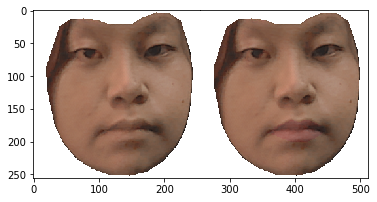

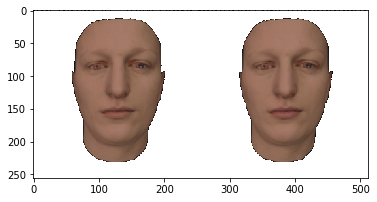

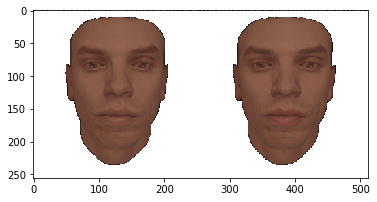

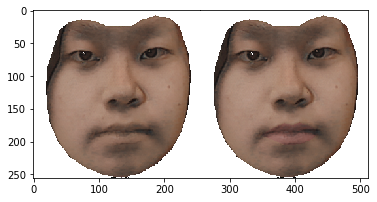

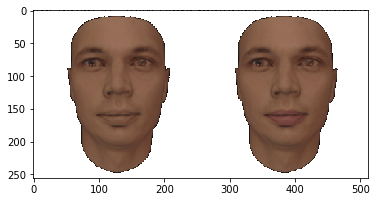

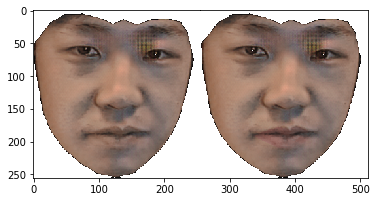

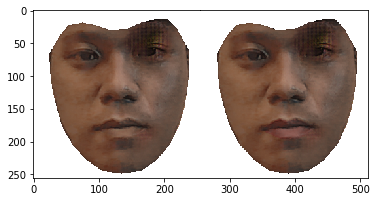

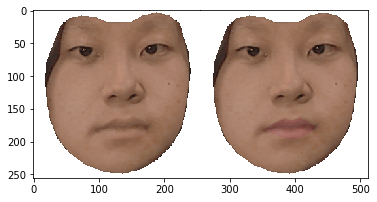

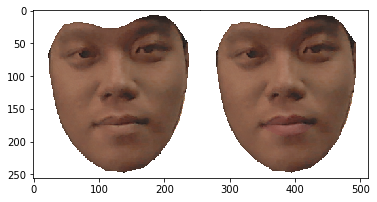

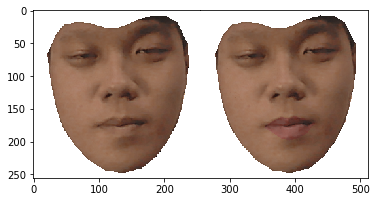

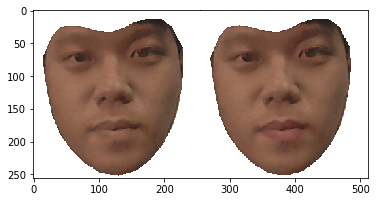

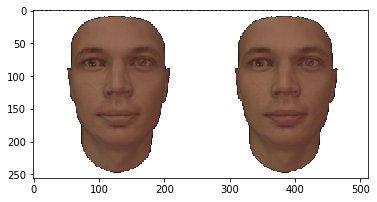

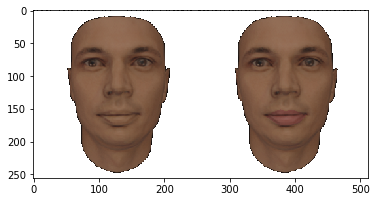

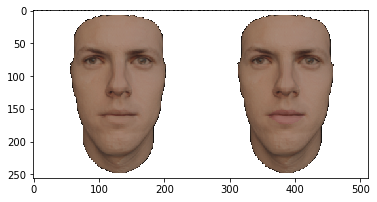

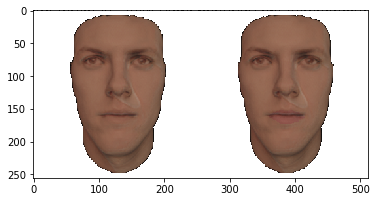

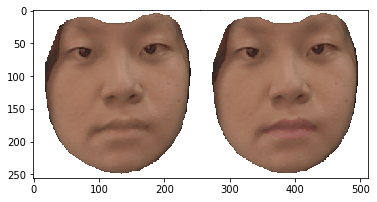

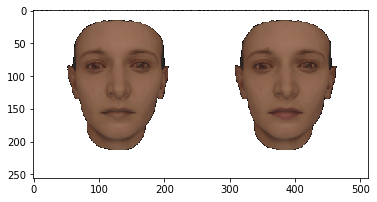

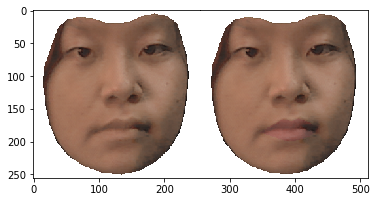

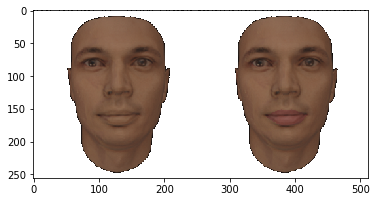

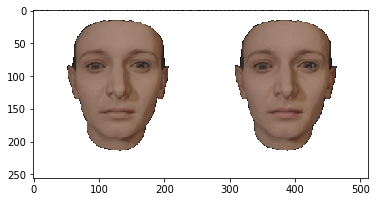

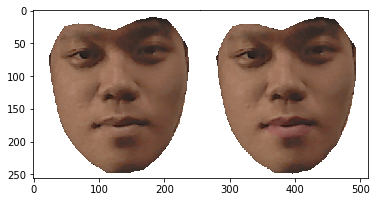

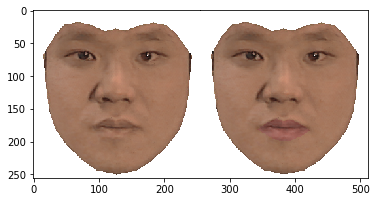

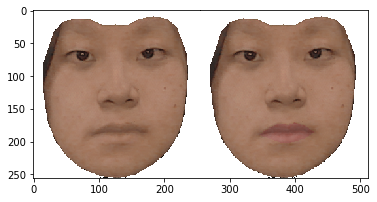

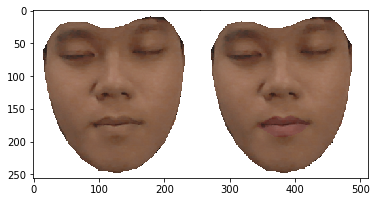

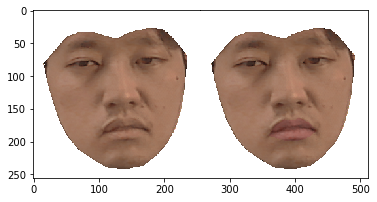

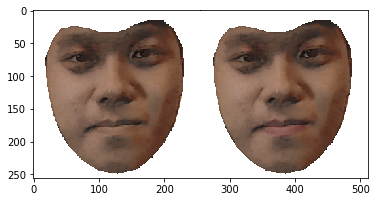

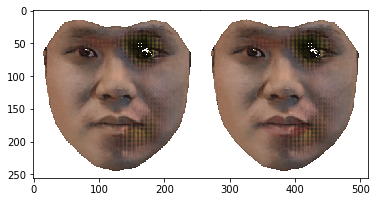

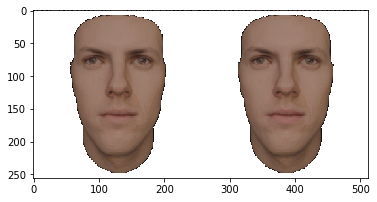

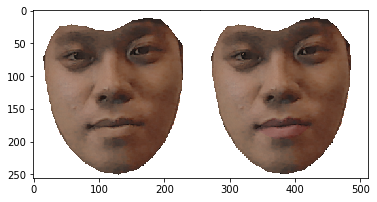

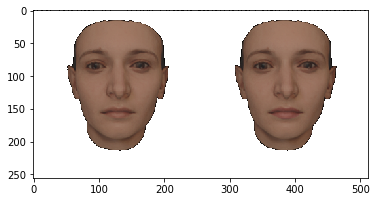

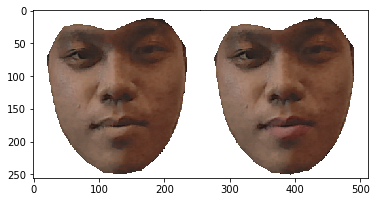

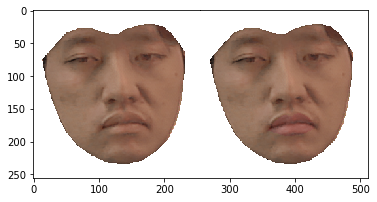

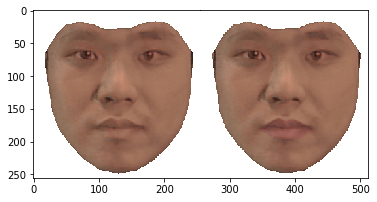

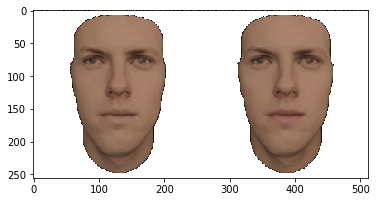

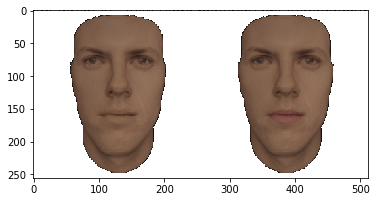

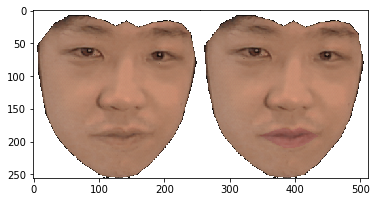

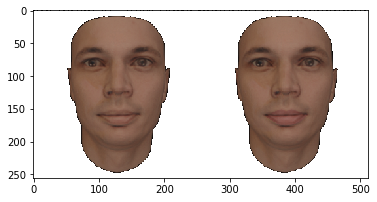

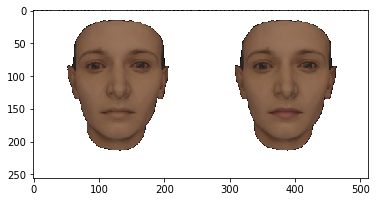

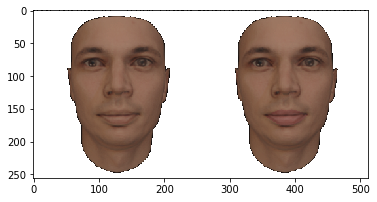

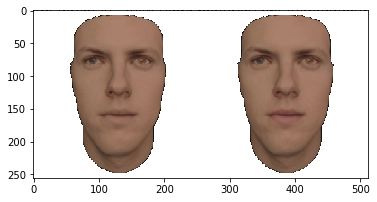

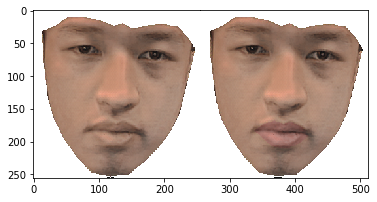

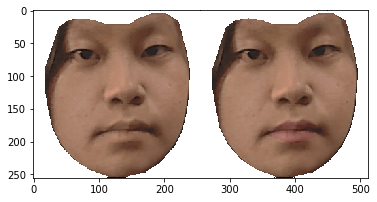

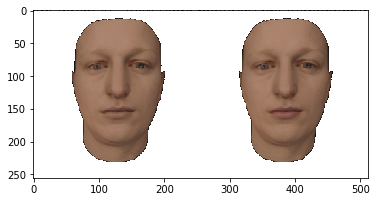

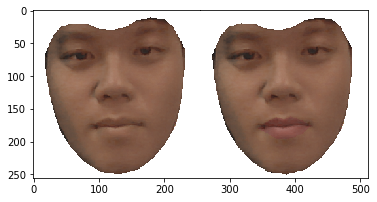

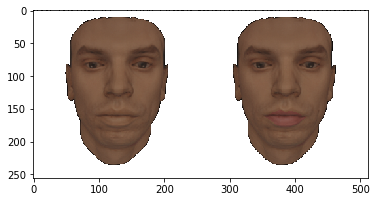

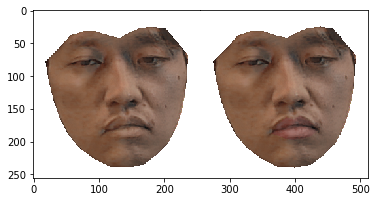

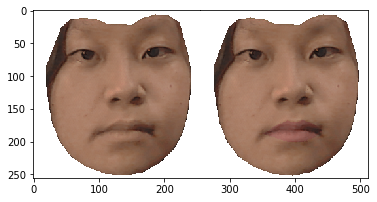

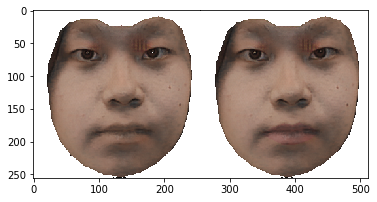

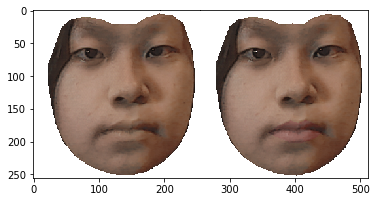

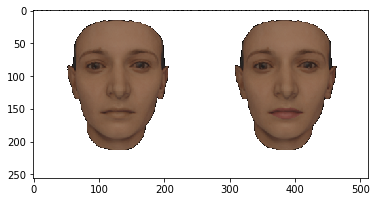

In [142]:
directory = glob.glob("/home/cgal/testing/white_bg/rev_my_model/*.png")
path = os.path.split(directory[0])[0]+"/relit2/"
if not os.path.exists(path):
    os.makedirs(path)

for i in directory :
    name = os.path.split(i)[1]
    image = cv.imread(i)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    new_image = np.zeros(image.shape, image.dtype)
    alpha = 1.0 # Simple contrast control
    beta = 0    # Simple brightness control
    # Initialize values
    try:
        alpha = float(1.5)
        beta = int(10)
    except ValueError:
        print('Error, not a number')
    # Do the operation new_image(i,j) = alpha*image(i,j) + beta
    # Instead of these 'for' loops we could have used simply:
    # new_image = cv.convertScaleAbs(image, alpha=alpha, beta=beta)
    # but we wanted to show you how to access the pixels :)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            for c in range(image.shape[2]):
                new_image[y,x,c] = np.clip(alpha*image[y,x,c] + beta, 0, 255)
    
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, 1.1) * 255.0, 0, 255)
    res = cv.LUT(new_image, lookUpTable)
    #img_gamma_corrected = cv.hconcat([image, res])
    
    ori_image = res
    mask,mouth_ori,brows_ori = createmask(ori_image)
    mouth_fake = color_harmonize(mouth_ori)
    brows_fake = sharpen(brows_ori)
    mask = np.array(mask)
    i_mask = np.invert(mask)
    fake_image = cv.bitwise_or(ori_image,ori_image,mask=i_mask)
    fake_image = mouth_fake+fake_image
    #sharp_image = sharpen(fake_image)
    result = cv.hconcat([ori_image, fake_image])
    cv.imwrite(path+name, cv.cvtColor(fake_image, cv.COLOR_RGB2BGR)) 
    
    plt.imshow(result)
    plt.show()

